In [66]:
from collections import defaultdict
from itertools import product

import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

sns.set_theme(color_codes=True)

### Часть первая, с блекджеком и стратегиями

1. Рассмотрим очень простую стратегию: говорить `stand`, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить `hit`. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [40]:
env = gym.make('Blackjack-v0')

In [41]:
def run_episode(env, pi, St2id):
    state = env.reset()
    states, rewards = [state], [0]
    for _ in range(1000):
        action = int(state[0]<19)
        state, reward, done, _ = env.step(pi[St2id[state]])
        states.append(state)
        rewards.append(reward)
        if done:
            break
    return states, rewards

In [42]:
# состояния
St = list(product(range(4,32),range(1,11),(False,True)))
St2id = {}
for i, st in enumerate(St):
    St2id[st]=i

In [43]:
simple_pi = [0]*len(St)
for st in St:
    s1, _, _ = st
    if s1 < 19:
        simple_pi[St2id[st]] = 1

In [44]:
def mc_prediction(pi, env, St2id, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    for _ in range(n_episodes):
        states, rewards = run_episode(env, pi, St2id)
        returns = 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    return value_table

In [46]:
def get_mc_reward(pi, env, St2id, n_iter=500000):
    value_table = mc_prediction(pi, env, St2id, n_iter)
    init_states = [r for (s, r) in value_table.items() if 12 <= s[0] <= 20]
    return np.mean(init_states)

In [47]:
# состояния с суммой от 12 до 20, так как состояния с суммой < 12 сводятся к этим
rew = get_mc_reward(simple_pi, env, St2id)
print(rew)

-0.16982591485269108


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [48]:
def get_a(pi, state, epsilon, nA):
    if np.random.rand() > epsilon:
        return pi[state] 
    else:
        return np.random.randint(nA)

def compute_policy_by_Q(Q):
    return np.argmax( Q, axis=1 )

In [49]:
def Q_learning_episode(env, pi, Q, nA, St2id, alpha=0.05, epsilon=0.03, gamma=0.9):
    s = env.reset()
    a = get_a(pi, St2id[s], epsilon, nA)
    for _ in range(1000):
        state_prime, reward, done, _ = env.step(a)
        a_prime = get_a(pi, St2id[state_prime], epsilon, nA)
        Q[St2id[s]][a] = Q[St2id[s]][a] + alpha * \
            (reward + gamma * np.max(Q[St2id[state_prime]]) - Q[St2id[s]][a])
        s, a = state_prime, a_prime
        if done:
            break

In [50]:
Q = np.zeros((len(St),2))
pi = compute_policy_by_Q(Q)
nA = 2 # 2 состояния
total_episodes=500000

for n in tqdm(range(total_episodes)):
    Q_learning_episode(env, pi, Q, nA, St2id, epsilon=0.03)
    pi = compute_policy_by_Q(Q)

100%|██████████| 500000/500000 [00:43<00:00, 11441.10it/s]


In [51]:
rew = get_mc_reward(pi, env, St2id)
print(rew)

-0.10007635834275382


In [52]:
param_grid = {'alpha': np.linspace(1e-3,3e-1,10), 'gamma': np.linspace(1e-3,3e-1,10)}

In [56]:
nA = 2 # 2 состояния
total_episodes=100000
param_list=[]
rew_list=[]
for param in tqdm(ParameterSampler(param_grid, n_iter=10, random_state=123)):
    Q = np.zeros((len(St),2))
    pi = compute_policy_by_Q(Q)
    for n in range(total_episodes):
        Q_learning_episode(env, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
        
    rew = get_mc_reward(pi, env, St2id)
    rew_list.append(rew)
    param_list.append(param)

100%|██████████| 10/10 [05:56<00:00, 35.68s/it]


In [59]:
param_list[np.argmax(rew_list)]

{'gamma': 0.1671111111111111, 'alpha': 0.001}

In [71]:
Q = np.zeros((len(St),2))
pi = compute_policy_by_Q(Q)
nA = 2 # 2 состояния
total_episodes=700000
cur_pos = 1
border = np.linspace(100,total_episodes+1,11)
history = []
for n in tqdm(range(total_episodes)):
    if border[cur_pos] < n:
        rew = get_mc_reward(pi, env, St2id)
        cur_pos += 1
        history.append((n, rew))
    Q_learning_episode(env, pi, Q, nA, St2id, epsilon=0.03, **param_list[np.argmax(rew_list)])
    pi = compute_policy_by_Q(Q)
rew = get_mc_reward(pi, env, St2id)
history.append((total_episodes, rew))

100%|██████████| 700000/700000 [05:53<00:00, 1977.41it/s] 


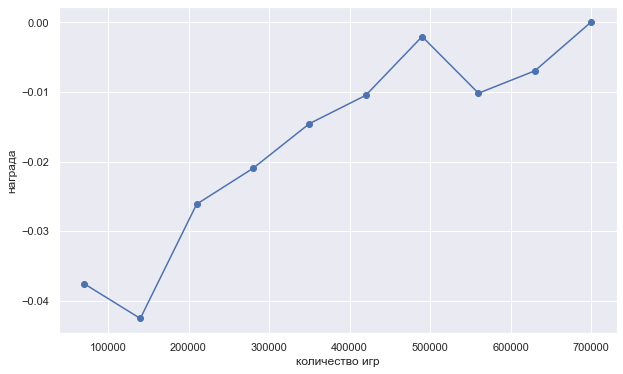

In [73]:
plt.figure(figsize=(10,6))
x, y = list(zip(*history))
ax, = plt.plot(x,y, linestyle='-', marker='o', color='b')
plt.xlabel('количество игр')
plt.ylabel('награда')
plt.show()

### Часть вторая, удвоенная

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [77]:
from blackjack_double import BlackjackDoubleEnv

In [78]:
double_env=BlackjackDoubleEnv()

In [22]:
Q = np.zeros((len(St),3))
pi = compute_policy_by_Q(Q)
nA = 3 # 2 состояния
total_episodes=500000

for n in tqdm(range(total_episodes)):
    Q_learning_episode(double_env, pi, Q, nA, St2id, epsilon=0.03)
    pi = compute_policy_by_Q(Q)

100%|██████████| 500000/500000 [00:43<00:00, 11385.51it/s]


In [23]:
# награда Q-learning double
rew = get_mc_reward(pi, double_env, St2id)
print(rew)

100%|██████████| 500000/500000 [00:30<00:00, 16407.05it/s]

-0.08603543438238026


In [ ]:
nA = 3 # 3 состояния
total_episodes=100000
param_list=[]
rew_list=[]
for param in tqdm(ParameterSampler(param_grid, n_iter=10, random_state=123)):
    Q = np.zeros((len(St),3))
    pi = compute_policy_by_Q(Q)
    for n in range(total_episodes):
        Q_learning_episode(double_env, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
        
    rew = get_mc_reward(pi, double_env, St2id)
    rew_list.append(rew)
    param_list.append(param)

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
nA = 3 # 2 состояния
total_episodes=500000

for param in ParameterSampler(param_grid, n_iter=10, random_state=123):
    Q = np.zeros((len(St),3))
    pi = compute_policy_by_Q(Q)
    for n in tqdm(range(total_episodes)):
        Q_learning_episode(double_env, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
    rew = get_mc_reward(pi, double_env, St2id)
    print(param, rew)

  0%|          | 2416/500000 [00:00<00:41, 12109.98it/s]

{'gamma': 0.2667777777777778, 'alpha': 0.001} -0.02644946000615704


  0%|          | 1192/500000 [00:00<00:41, 11908.68it/s]

{'gamma': 0.001, 'alpha': 0.23355555555555557} -0.07043554133058579


  0%|          | 1220/500000 [00:00<00:40, 12195.97it/s]

{'gamma': 0.06744444444444445, 'alpha': 0.2667777777777778} -0.1255552828143272


  0%|          | 1200/500000 [00:00<00:41, 11994.95it/s]

{'gamma': 0.2667777777777778, 'alpha': 0.06744444444444445} -0.04548291055750132


  0%|          | 1230/500000 [00:00<00:40, 12291.04it/s]

{'gamma': 0.10066666666666667, 'alpha': 0.20033333333333334} -0.07851105918877423


  0%|          | 2337/500000 [00:00<00:42, 11781.82it/s]

{'gamma': 0.001, 'alpha': 0.001} -0.012131505812639172


  0%|          | 2308/500000 [00:00<00:42, 11582.36it/s]

{'gamma': 0.1671111111111111, 'alpha': 0.001} -0.02508386353365977


  0%|          | 2272/500000 [00:00<00:44, 11243.99it/s]

{'gamma': 0.001, 'alpha': 0.1671111111111111} -0.038950788328225135


  0%|          | 1213/500000 [00:00<00:41, 12126.74it/s]

{'gamma': 0.03422222222222222, 'alpha': 0.2667777777777778} -0.09731809256759906


100%|██████████| 100000/100000 [00:03<00:00, 25940.63it/s]

{'gamma': 0.1338888888888889, 'alpha': 0.001} -0.0024079921715451282


### Часть третья, в главной роли — Дастин Хоффман

4. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [12]:
from blackjack_count_double import BlackjackDoubleCountEnv

In [13]:
double_env_count = BlackjackDoubleCountEnv()

In [18]:
# состояния
St = list(product(range(4,32),range(1,11),(False,True), range(22*4+1)))
St2id = {}
for i, st in enumerate(St):
    St2id[st]=i

In [29]:
nA = 3 # 2 состояния
total_episodes=100000

for param in tqdm(ParameterSampler(param_grid, n_iter=10, random_state=123)):
    Q = np.zeros((len(St),3))
    pi = compute_policy_by_Q(Q)
    for n in range(total_episodes):
        Q_learning_episode(double_env_count, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
    rew = get_mc_reward(pi, double_env_count, St2id)
    print(param, rew)

 10%|█         | 1/10 [01:12<10:55, 72.89s/it]

{'gamma': 0.2667777777777778, 'alpha': 0.001} -0.10893940429231434


 20%|██        | 2/10 [02:26<09:45, 73.15s/it]

{'gamma': 0.001, 'alpha': 0.23355555555555557} -0.10039150075769915


 30%|███       | 3/10 [03:42<08:38, 74.04s/it]

{'gamma': 0.06744444444444445, 'alpha': 0.2667777777777778} -0.09407704975043381


 40%|████      | 4/10 [04:57<07:25, 74.25s/it]

{'gamma': 0.2667777777777778, 'alpha': 0.06744444444444445} -0.08873627264232117


 50%|█████     | 5/10 [06:11<06:10, 74.10s/it]

{'gamma': 0.10066666666666667, 'alpha': 0.20033333333333334} -0.09746443881022229


 50%|█████     | 5/10 [06:43<06:43, 80.68s/it]


KeyboardInterrupt: 

In [21]:
Q = np.zeros((len(St),3))
pi = compute_policy_by_Q(Q)
nA = 3 # 2 состояния
total_episodes=1000000

for n in tqdm(range(total_episodes)):
    Q_learning_episode(double_env_count, pi, Q, nA, St2id, alpha=0.001,epsilon=0.01, gamma=0.133)
    pi = compute_policy_by_Q(Q)
# награда Q-learning double
value_table = mc_prediction(pi, double_env_count, St2id, 100000)
init_states = [r for ((s1, _, _,_), r) in value_table.items() if 12 <= s1 <= 20]
print(np.mean(init_states))

100%|██████████| 100000/100000 [00:07<00:00, 13246.70it/s]

-0.036156764819441876
